In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from keras.datasets import mnist
from keras.layers import Dense , Input , BatchNormalization , LeakyReLU , Activation
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using Theano backend.


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

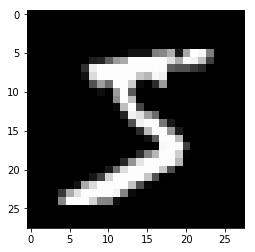

In [3]:
plt.imshow(X_train[0] , cmap='gray')
plt.show()

In [4]:
def latent_layer(n_samples , sample_size):
    return np.random.normal(size=(n_samples , sample_size))

In [5]:
latent_layer(1,100)

array([[ 6.55987358e-01, -6.63535439e-01, -7.16355526e-01,
         1.00168321e+00,  1.17390259e+00, -2.10655769e-01,
         9.68888644e-01,  2.11780088e-01,  1.65137137e+00,
         1.24327429e-01, -9.97341628e-01,  4.54423730e-01,
        -6.50573300e-01,  8.93176190e-01,  5.32724060e-01,
         2.24112569e-01, -1.49187634e+00,  1.81342731e+00,
        -1.15413174e+00,  1.22559427e+00,  6.25122520e-01,
        -1.77778784e-02,  1.60825556e+00,  9.37712195e-01,
         1.01555961e+00, -1.35959019e+00,  1.39855363e+00,
         1.92708921e-01, -5.94352760e-02,  1.39164812e+00,
         7.72892412e-01, -2.31540083e-01,  1.85706410e-02,
        -4.16668380e-01, -1.15344942e+00,  2.02034359e+00,
         1.31872651e+00,  6.07409222e-01,  9.22944656e-01,
        -3.72912564e-04,  2.80570500e-02, -9.33991368e-01,
        -1.48368442e+00,  1.21177385e+00, -6.04974156e-01,
         6.10294529e-01,  1.02539951e+00, -6.11903872e-01,
        -9.47662906e-01,  1.48115450e+00, -2.24961382e+0

In [6]:
generator = Sequential([
    Dense(128 , input_shape = (100,)),
    LeakyReLU(alpha = 0.01),
    Dense(784),
    Activation('tanh')
] , name = 'generator')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation_1 (Activation)    (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [7]:
discriminator = Sequential([
    Dense(128 , input_shape=(784,)),
    LeakyReLU(alpha = 0.01),
    Dense(1),
    Activation('sigmoid')
] , name = 'discriminator')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [9]:
gan = Sequential([generator ,
                 discriminator])
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 784)               114064    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 214,673
Non-trainable params: 0
_________________________________________________________________


In [10]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [11]:
make_trainable(discriminator , False)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 0
Non-trainable params: 100,609
_________________________________________________________________


In [23]:
def makegan(n_input , g_lr , d_lr , alpha , g_hidden , d_hidden):
    generator = Sequential([
        Dense(units = g_hidden , input_shape = (n_input , )),
        LeakyReLU(alpha = alpha),
        Dense(784),
        Activation('tanh'),
    ] , name = 'generator')
    
    discriminator = Sequential([
        Dense(units = d_hidden , input_shape=(784 , )),
        LeakyReLU(alpha = alpha),
        Dense(1),
        Activation('sigmoid')
    ],name = 'discriminator')
    
    gan = Sequential([
        generator , 
        discriminator
    ])
    
    discriminator.compile(optimizer = Adam(lr = d_lr) , loss = 'binary_crossentropy')
    gan.compile(optimizer = Adam(lr = g_lr) , loss = 'binary_crossentropy')
    
    return gan , generator, discriminator

In [13]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [14]:
def reprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

In [15]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

In [16]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [27]:
n_input     = 100     
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  
d_learning_rate = 0.001   
epochs          = 100
batch_size      = 64     
eval_size       = 16     
smooth          = 0.1

y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

gan , generator , discriminator = makegan(n_input , g_learning_rate , d_learning_rate,
                                         leaky_alpha , g_hidden_size , d_hidden_size)
losses = []

for epoch in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        x_train = X_train_real[i*batch_size : (i+1)*batch_size]
        latent_samples = latent_layer(batch_size , n_input)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        make_trainable(discriminator , True)
        discriminator.train_on_batch(x_train, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)
        
        make_trainable(discriminator , False)
        gan.train_on_batch(latent_samples, y_train_real)
        
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = latent_layer(eval_size, n_input)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real) + discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real)
    losses.append((d_loss , g_loss))
    
    print('epoch ',epoch , end=' ')
    print('generator loss : ' , g_loss , end = ' ')
    print('discriminator loss : ' , d_loss)
    

/home/nilesh/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch  0 generator loss :  2.9762557 discriminator loss :  0.19396114


/home/nilesh/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch  1 generator loss :  2.9309058 discriminator loss :  0.16464868
epoch  2 generator loss :  2.3354928 discriminator loss :  0.16485173
epoch  3 generator loss :  1.9852487 discriminator loss :  0.29786623
epoch  4 generator loss :  6.462553 discriminator loss :  0.826571
epoch  5 generator loss :  0.9315147 discriminator loss :  0.6421274
epoch  6 generator loss :  3.498249 discriminator loss :  0.2323856
epoch  7 generator loss :  2.143071 discriminator loss :  0.3605205
epoch  8 generator loss :  1.9532846 discriminator loss :  0.27613446
epoch  9 generator loss :  2.1929197 discriminator loss :  0.5496093
epoch  10 generator loss :  4.2878985 discriminator loss :  0.29181978
epoch  11 generator loss :  1.9981167 discriminator loss :  0.5808022
epoch  12 generator loss :  3.5672019 discriminator loss :  0.09813492
epoch  13 generator loss :  2.0411863 discriminator loss :  0.34673196
epoch  14 generator loss :  2.6201384 discriminator loss :  0.17863299
epoch  15 generator loss 

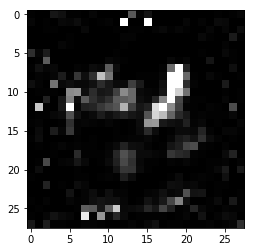

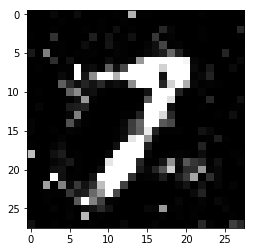

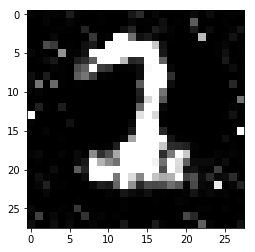

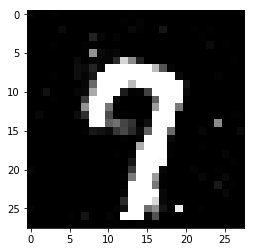

In [30]:
latent_samples = latent_layer(20 , n_input)
images = generator.predict(latent_samples)
plt.imshow(reprocess(images[0]) , cmap = 'gray')
plt.show()
plt.imshow(reprocess(images[1]) , cmap = 'gray')
plt.show()
plt.imshow(reprocess(images[2]) , cmap = 'gray')
plt.show()
plt.imshow(reprocess(images[3]) , cmap = 'gray')
plt.show()

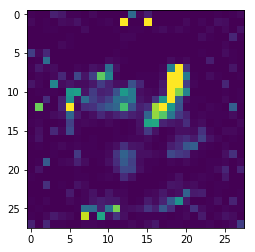

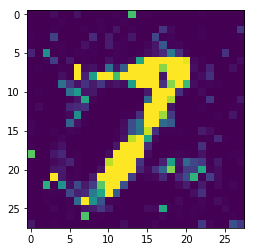

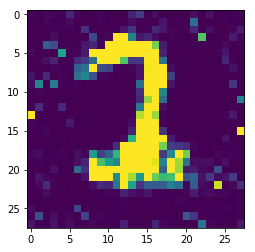

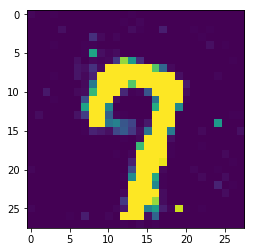

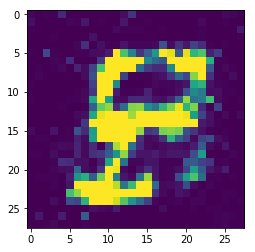

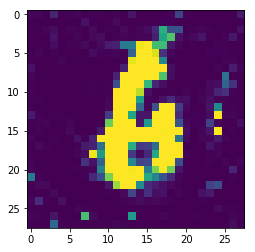

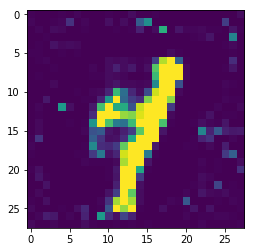

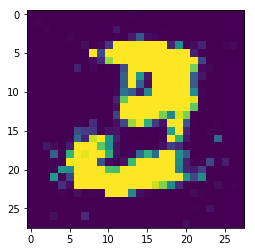

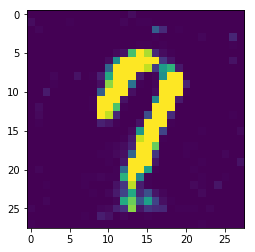

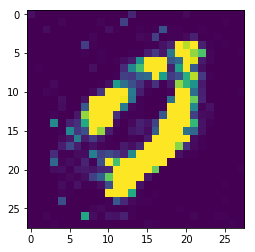

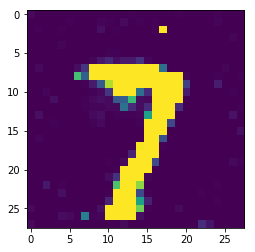

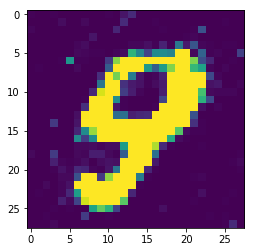

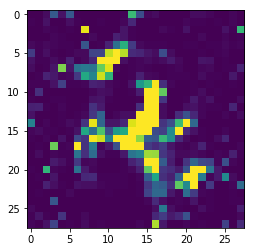

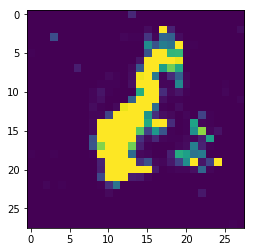

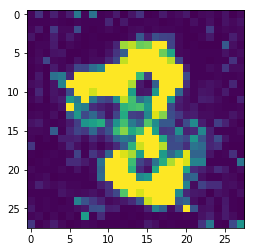

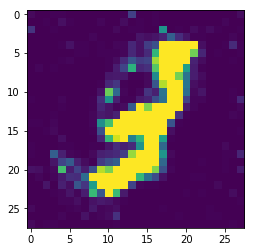

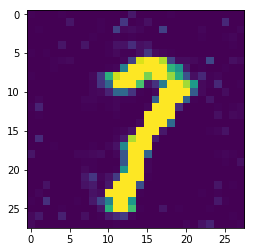

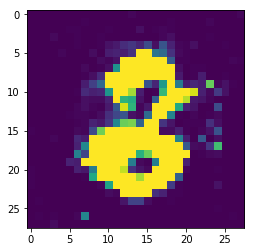

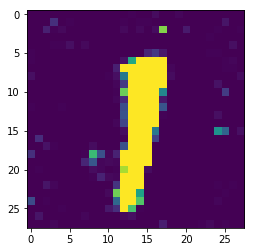

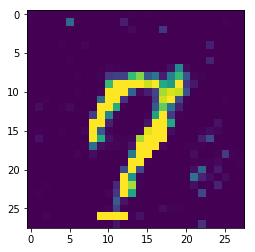

In [32]:
for image in images:
    plt.imshow(reprocess(image))
    plt.show()